In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random

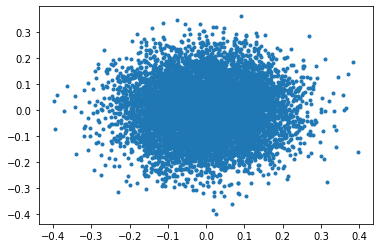

In [3]:
npt=10000
pts00=jnp.array(np.random.randn(npt,2))
pts00=pts00/(jnp.max(abs(pts00))*2.5)
plt.plot(pts00[:,0], pts00[:,1],'.')

In [4]:
#### size of image. memory usage scales with N^2 of this.
boxsz=sz=256

#### precompute Fourier indices 
idx=jnp.indices((boxsz,boxsz))-boxsz//2
idx=jnp.fft.ifftshift(idx)
idx=idx[:,:,:boxsz//2+1]
idxft=(idx/sz).astype(jnp.float32)[:, None, :,:]
rrft=jnp.sqrt(jnp.sum(idx**2, axis=0)).astype(jnp.float32)## batch, npts, x-y
amp=jnp.exp(-rrft*.1)


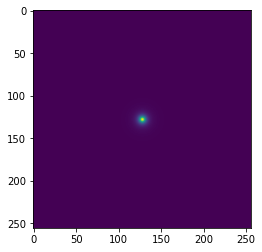

In [5]:
plt.imshow(jnp.fft.fftshift(jnp.fft.irfft2(amp)))

In [6]:
pts00[None,:,:].shape

(1, 10000, 2)

In [7]:
print(idxft.shape)

(2, 1, 256, 129)


In [8]:
sz

256

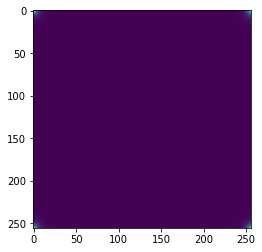

In [9]:

amp_r = jnp.fft.irfft2(amp)
amp_rx = amp_r[0]
amp_ry = amp_r[:,0]
plt.imshow(amp_r)
#plt.plot(amp_ry-amp_rx)

In [10]:
def gen_gauss_x(centre, x, sig, sz, amp):
    return jnp.exp(-(x-centre)**2/(2*sig**2)) * max_amp

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, None,None,None,None))

#def gen_gauss_x_sum(centres, x, sig, sz, amp):
#    return jnp.sum(gen_gauss_x_vmap(centres, x, sig, sz, amp), axis=0)
   
def pts2img_one(pts):
    p_x = gen_gauss_x_vmap(pts[:,0], idx_r, sig, sz, max_amp)
    p_y = gen_gauss_x_vmap(pts[:,1], idx_r, sig, sz, max_amp) 
    return jnp.matmul(p_x.transpose(), p_y).transpose()

pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)

0.0013395245
0.009587567


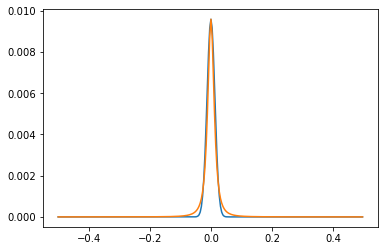

In [12]:
#print(p%pprint00.shape)
idx_r = jnp.arange(-sz/2, sz/2)/sz
#print(idx_r)
sig = 0.0129
centre = 0 #pts00[4,0] #0
max_amp = jnp.max(amp_rx)
gauss_x = gen_gauss_x(idx_r, centre, sig, sz, max_amp)
plt.plot(idx_r,gauss_x)
plt.plot(idx_r, jnp.fft.fftshift(amp_rx))
#plt.plot(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)    )
print(jnp.max(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)))
print(jnp.max(gauss_x))

(10000, 256)
(256, 256)


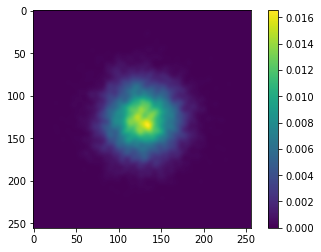

In [33]:
#print(gen_gauss_x_vmap(pts00[:,0],idx_r, sig, sz, max_amp).shape)
p_x = gen_gauss_x_vmap(pts00[:,0], idx_r, sig, sz, max_amp)
p_y = gen_gauss_x_vmap(pts00[:,1], idx_r, sig, sz, max_amp)
print(p_x.shape)
p_img = pts2img_one(pts00)
print(p_img.shape)
plt.imshow(p_img);plt.colorbar()

(1, 256, 129)


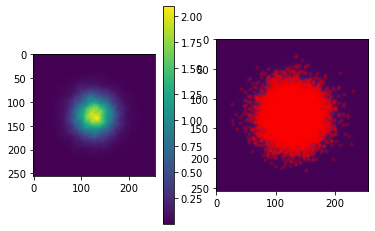

In [34]:
def pts2img(pts):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    bposft=bposft[:, :, :, None, None]
    
    ## this is the big 4d matrix for all Gaussian images
    ## (batchsz, # Gaussian, sz, sz//2+1)
    cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]

    ## here we keep amplitude constand for simplification
    ## amp should be (sz, sz//2+1)
    pgauss_real=jnp.cos(cpxang)*amp
    pgauss_imag=-jnp.sin(cpxang)*amp

    imgs_real=jnp.sum(pgauss_real, axis=1)
    imgs_imag=jnp.sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)



imgs_real, imgs_imag=pts2img(pts00[None,:,:])#.astype(jnp.float32))
print(imgs_real.shape)
#imgs_cpx=np.complex(imgs_real, imgs_imag)
imgs_cpx = imgs_real + 1j*imgs_imag
imgs_out=jnp.fft.irfft2(imgs_cpx)

img=imgs_out[0]
plt.subplot(1,2,1)
plt.imshow(img)
plt.colorbar()
p=pts00*sz+sz//2
plt.subplot(1,2,2)
plt.imshow(img)
plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

0.093568936
2.089735


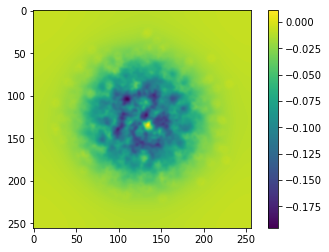

In [35]:
scaling = jnp.max(img)/jnp.max(p_img)
p_img = p_img*scaling
plt.imshow(p_img-img); plt.colorbar()
print(jnp.max(jnp.abs(p_img-img)/jnp.max(img)))
print(jnp.max(img))

In [36]:
def loss_func(pts):
    imgs_real, imgs_imag=pts2img(pts)
    return jnp.sum(imgs_real**2 + imgs_imag**2)

grad_loss = jax.grad(loss_func)

In [42]:
def loss_func2(pts):
    imgs = pts2img_vmap(pts)
    imgs_f = jnp.fft.fft2(imgs)
    return jnp.sum(jnp.conj(imgs)*imgs)
grad_loss2 = jax.grad(loss_func2)

In [39]:
loss_func(pts00[None,:,:])
gp = grad_loss(pts00[None,:,:])

In [43]:
loss_func2(pts00[None,:,:])
gp2 = grad_loss2(pts00[None,:,:])

0.105876185


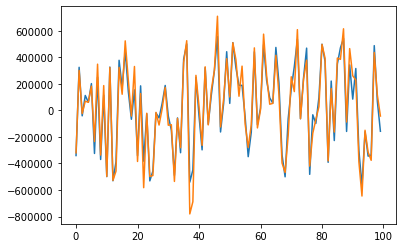

In [67]:
gp2_scaled = gp2/jnp.max(gp2)*jnp.max(gp)
plt.plot(gp[0,:100,0])
plt.plot(gp2_scaled[0,:100,0])
rel_err = jnp.mean(jnp.abs(gp-gp2_scaled))/jnp.max(jnp.abs(gp))
print(rel_err)

(32, 256, 129) (32, 256, 129)


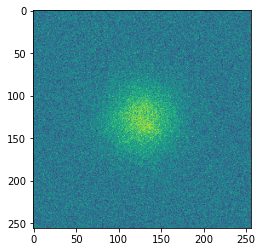

In [68]:
#### make some particle images for training later
##   they should stay in CPU as well
nptcl=32
ptcls=0.5*jnp.array(np.random.randn(nptcl, sz,sz))+img
plt.imshow(ptcls[0])
ptcls_cpx=jnp.fft.rfft2(ptcls)
ptcls_real=jnp.real(ptcls_cpx).astype(jnp.float32)
ptcls_imag=jnp.imag(ptcls_cpx).astype(jnp.float32)
print(ptcls_real.shape, ptcls_imag.shape)

In [69]:
#### now make corresponding images from the model
##   note here the memory consumption already increase linear to Gaussian number
##   since tensorflow does not release memory for the 4d matrix

#Bogdan: replacing this with something else of the same shape
#pp=model(jnp.zeros((nptcl,2), dtype=jnp.float32))
pp = jnp.array(np.random.randn(nptcl, 2048, 2))

print(pp.shape)
imgs_cpx=pts2img(pp)
print(imgs_cpx[0].shape)

(32, 2048, 2)
(32, 256, 129)


In [70]:
loss_func(pp)

DeviceArray(1.396371e+08, dtype=float32)

In [77]:
nptcl = 1000
pp_train = jnp.array(np.random.randn(nptcl, 2048, 2))
pp_train.shape


(1000, 2048, 2)

#### Don't run these for large dimensions

In [ ]:
t0 = time.time()
ll1 = loss_func(pp)
print(time.time()-t0)

In [ ]:
t0 = time.time()
gg1 = grad_loss(pp)
print(time.time()-t0)

#### OK to run these

In [80]:
t0 = time.time()
ll2 = loss_func2(pp_train)
print(time.time()-t0)

8.442190885543823


In [82]:
t0 = time.time()
gg2 = grad_loss2(pp_train)
print(time.time()-t0)

25.693955183029175


In [83]:
pp_train.shape

(1000, 2048, 2)